In [1]:
%cd ~/github/agn_lf/
# %cd ..
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import source.utils as utils
import numpy as np
from scipy.interpolate import interp1d as intp
from scipy.optimize import curve_fit
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.table as table
import astropy.units as u
import source.selection_criteria as sc
from sklearn.neighbors import KernelDensity

cosmo = af.setup_cosmology()

/Users/runburg/github/agn_lf


In [2]:
catalog = table.Table.read('./data/ir_and_xray.fits')
outfile = 'lf_ir_crossmatch_ir_selected_fixed_coverage'
specz = 'zspec_1'
photoz = 'z1_median'
specz2 = 'redshift'
photoz2 = 'ZPHOT'

flux36 = 'f_ap_irac_i1'
flux45 = 'f_ap_irac_i2'
flux58 = 'f_ap_irac_i3'
flux80 = 'f_ap_irac_i4'
flux240 = 'f_mips_24'

# print(catalog[flux58][catalog[flux58] < 0])
never_nan = (np.nan_to_num(catalog[flux58], nan=-99) > 0) & (np.nan_to_num(catalog[flux80], nan=-99) > 0) #& (np.nan_to_num(catalog[specs], nan=-99) > 0)

selected_agn = sc.select_ir(catalog, flux36, flux45, flux58, flux80, selection_cuts='lacy05')
ir_ct_lacy = catalog[selected_agn]
ct_lacy = ir_ct_lacy[(np.nan_to_num(ir_ct_lacy[photoz], nan=-99) > 0 ) | (np.nan_to_num(ir_ct_lacy[specz], nan=-99) > 0)]
# print(len(ct_lacy))
# band + units
wavelength = 5.8
unit_conversion = 3 / wavelength * 1e-15
zs = np.array([row[specz] if row[specz] > 0 else row[photoz] if row[photoz] > 0 else row[specz2] if row[specz2] > 0 else row[photoz2] for row in catalog])
# print(np.sum(zs < 0))
spectral_index = np.log10(catalog[flux240].data/catalog[flux58].data) / np.log10(24/5.8)

catalog['ir_selected'] = selected_agn.astype(bool).filled(False)
catalog['ir_l'] = 4 * np.pi * cosmo.luminosity_distance(zs).to(u.cm).value**2 * catalog[flux58].data * unit_conversion * (1 + zs)**(-1 + spectral_index)


# xzs = np.array([row[specz] if row[specz] > 0 else row[photoz] for row in catalog])
xzs = np.array([row[specz2] if row[specz2] > 0 else row[photoz2] if row[photoz2] > 0 else row[specz] if row[specz] > 0 else row[photoz] for row in catalog])
spectral_index = np.log10(catalog['HB_FLUX'].data/catalog['SB_FLUX'].data) / np.log10(6/1.25)
catalog['x_l'] = 4 * np.pi * cosmo.luminosity_distance(xzs).to(u.cm).value**2 * catalog['FB_FLUX'] * (1 + xzs)**(-1 + spectral_index)
catalog['x_selected'] = (catalog['x_l'] > 3e42).filled(False)
# print(catalog['x_selected'])
catalog['both_selected_and_good'] = catalog['x_selected'] & catalog['ir_selected'] & ~catalog['x_l'].mask & ~catalog['ir_l'].mask
print(np.sum(catalog['x_selected']), np.sum(catalog['ir_selected']), np.sum(catalog['both_selected_and_good']))
catalog['full_zs'] = np.array([row[specz2] if row[specz2] > 0 else row[specz] if row[photoz2] > 0 else row[photoz2] if row[specz] > 0 else row[photoz] if row[photoz] > 0 else np.nan for row in catalog])
print(len(zs), len(xzs))

ra_up = 36.5
ra_down = 34.25
dec_up = -4.0
dec_down = -5.5 
catalog = catalog[(ra_down < catalog['RA_2']) & (catalog['RA_2'] < ra_up)& (dec_down < catalog['DEC_2']) & (catalog['DEC_2'] < dec_up)]
    
# band + units
wavelength = 5.8
unit_conversion = 3 / wavelength * 1e-15
flux_limit = 43 * unit_conversion

# K-correction
spectral_index = np.log10(ct_lacy[flux240].data/ct_lacy[flux58].data) / np.log10(24/5.8)

cross_z_ir = np.array([row[specz] if row[specz] > 0 else row[photoz] for row in ct_lacy])

cross_l_ir = 4 * np.pi * cosmo.luminosity_distance(cross_z_ir).to(u.cm).value**2 * ct_lacy[flux58].data * unit_conversion * (1 + cross_z_ir)**(-1 + spectral_index)

specz = 'redshift'
photoz = 'ZPHOT'
ct_lacy = catalog[(np.nan_to_num(catalog[photoz], nan=-99) > 0 ) | (np.nan_to_num(catalog[specz], nan=-99) > 0)]

cross_z_x = np.array([row[specz] if row[specz] > 0 else row[photoz] for row in ct_lacy])

spectral_index = np.log10(ct_lacy['HB_FLUX'].data/ct_lacy['SB_FLUX'].data) / np.log10(6/1.25)

cross_l_x = 4 * np.pi * cosmo.luminosity_distance(cross_z_x).to(u.cm).value**2 * ct_lacy['FB_FLUX'] * (1 + cross_z_x)**(-1 + spectral_index)



cross_cat = catalog

# print(len(cross_z_ir), len(cross_z_x))

/usr/local/lib/python3.8/site-packages/astropy/cosmology/core.py:1920: RuntimeWarning: invalid value encountered in sqrt
  return 2 * np.sqrt(x) * hyp2f1(1./6, 1./2, 7./6, -x**3)


1808 1505 1481
2042 2042


In [3]:
catalog = table.Table.read('./data/master_cat_irac3_mips24')
outfile = 'lf_ir_montecarlo_with_incompleteness'
specz = 'zspec' 
photoz = 'z1_median'

flux36 = 'f_ap_irac_i1'
flux45 = 'f_ap_irac_i2'
flux58 = 'f_ap_irac_i3'
flux80 = 'f_ap_irac_i4'
flux240 = 'f_mips_24'

# print(catalog[flux58][catalog[flux58] < 0])
never_nan = (np.nan_to_num(catalog[flux58], nan=-99) > 0) & (np.nan_to_num(catalog[flux80], nan=-99) > 0) #& (np.nan_to_num(catalog[specs], nan=-99) > 0)

selected_agn = sc.select_ir(catalog[never_nan], flux36, flux45, flux58, flux80, selection_cuts='lacy05')
ct_lacy = catalog[never_nan][selected_agn]
ct_lacy = ct_lacy[(np.nan_to_num(ct_lacy[photoz], nan=-99) > 0 ) | (np.nan_to_num(ct_lacy[specz], nan=-99) > 0)]
print(len(ct_lacy))

cosmo = af.setup_cosmology()
catalog = ct_lacy

ir_in_cross_region = (ra_down < catalog['ra_1']) & (catalog['ra_1'] < ra_up)& (dec_down < catalog['dec_1']) & (catalog['dec_1'] < dec_up)
# band + units
wavelength = 5.8
unit_conversion = 3 / wavelength * 1e-15
flux_limit = 43 * unit_conversion

# K-correction
spectral_index = np.log10(ct_lacy[flux240].data/ct_lacy[flux58].data) / np.log10(24/5.8)

ir_z = np.array([row[specz] if row[specz] > 0 else row[photoz] for row in ct_lacy])

ir_l = 4 * np.pi * cosmo.luminosity_distance(ir_z).to(u.cm).value**2 * ct_lacy[flux58].data * unit_conversion * (1 + ir_z)**(-1 + spectral_index)
print(len(ir_z[ir_in_cross_region & (ir_z > 0.5) & (ir_z < 4)]))

5914
1802


In [4]:
xservs_catalog = table.Table.read('./data/tableA.v01.fits')
xservs_catalog = xservs_catalog[(xservs_catalog['ZPHOT'] > 0 ) | (xservs_catalog['ZSPEC'] > 0)]

spectral_index = np.log10(xservs_catalog['HB_FLUX'].data/xservs_catalog['SB_FLUX'].data) / np.log10(6/1.25)

z = np.array([row['ZSPEC'] if row['ZSPEC'] > 0 else row['ZPHOT'] for row in xservs_catalog])

l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2 * xservs_catalog['FB_FLUX'] * (1 + z)**(-1 + spectral_index)

selected_agn = l > 3e42

catalog = xservs_catalog[selected_agn]
x_in_cross_region = (ra_down < catalog['RA']) & (catalog['RA'] < ra_up)& (dec_down < catalog['DEC']) & (catalog['DEC'] < dec_up)

x_l = l[selected_agn]
x_z = z[selected_agn]
print(len(l))

4505


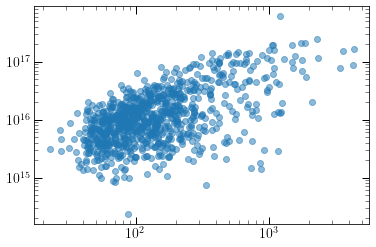

In [5]:
utils.configure_plot_params()
sources = cross_cat[photoz] < 1.5
ratio = cross_cat[sources][flux58]/cross_cat[sources]['FB_FLUX']
plt.scatter(cross_cat[sources][flux58], ratio, alpha=0.5)
plt.xscale('log')
plt.yscale('log')

0
[ 0.51290447 21.31888984]


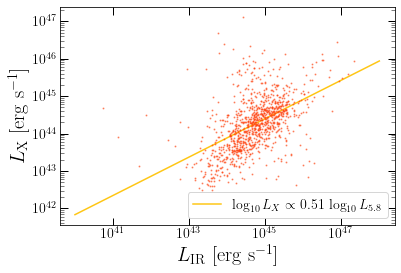

In [18]:
fig, ax = plt.subplots()

ax.scatter(cross_cat['ir_l'][cross_cat['both_selected_and_good']], cross_cat['x_l'][cross_cat['both_selected_and_good']], color='xkcd:orangered', s=1, alpha=0.5)
ax.set_xlabel(r'$L_\mathrm{IR}$ [erg s$^{-1}$]')
ax.set_ylabel(r'$L_\mathrm{X}$ [erg s$^{-1}$]')
ax.set_xscale('log')
ax.set_yscale('log')

# print(np.sum(np.isnan(cross_cat['x_l'][cross_cat['ir_selected']].filled(np.nan))))
def exp_fit(x, A, b, c):
    return A * x**b + c

def lin_fit(x, m, b):
    return m * x + b
# def lin_fit(x, m):
#     return m * x
print(np.sum(np.isinf(cross_cat['x_l'][cross_cat['both_selected_and_good']])))

# fitparams, fitcov = curve_fit(exp_fit, cross_cat['ir_l'][cross_cat['both_selected_and_good']], cross_cat['x_l'][cross_cat['both_selected_and_good']], p0=[1, 1, 50], bounds=([1, 0, 0], [1e16, 3, 1e3]))
fitparams, fitcov = curve_fit(lin_fit, np.log10(cross_cat['ir_l'][cross_cat['both_selected_and_good']]), np.log10(cross_cat['x_l'][cross_cat['both_selected_and_good']]), p0=[0.9, 1])
print(fitparams)
ls = np.logspace(40, 48, num=50)
ax.plot(ls, 10**lin_fit(np.log10(ls), *fitparams), color='xkcd:golden yellow', zorder=-5, label=rf'$\log_{{10}}L_X\propto {fitparams[0]:.2f}\,\log_{{10}}L_{{5.8}}$')
# ax.plot(ls, exp_fit(ls, *fitparams), color='xkcd:golden yellow', zorder=-5, label=rf'$\log_{{10}}L_X\propto {fitparams[1]:.2f}\,\log_{{10}}L_{{IR}}$')
# ax.fill_between(ls, exp_fit(ls, *(fitparams - np.sqrt(np.diag(fitcov)))), exp_fit(ls, *(fitparams + np.sqrt(np.diag(fitcov)))), color='xkcd:golden yellow', zorder=-5, alpha=0.5)
ax.legend()
fig.savefig('./output/paper_plots/lir_vs_lx.pdf', bbox_inches='tight')

In [7]:
plot_files = ['./output/lf_xray.npz', './output/lf_ir.npz']
labs = ['XLF', 'IRLF']
otherruns = {}
for lab, fil in zip(labs, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
        l_bins = infile['l_bins']
        z_bins = infile['z_bins']
    otherruns[lab] = [lfv, lfe, l_bins, z_bins]

In [8]:
yencho_ldde = {'A': 10**-6.12, 
               'gamma1': 0.956, 
               'gamma2': 2.3,
               'Lstar': 10**44.078,
               'zcstar': 1.964,
               'p1': 5.13,
               'p2': -2.51,
               'alpha': 0.255,
               'La': 10**44.889
              }
silverman_ldde = {'A': 10**-6.163, 
               'gamma1': 2.15, 
               'gamma2': 1.10,
               'Lstar': 10**44.33,
               'zcstar': 1.89,
               'p1': 4.22,
               'p2': -3.27,
               'alpha': 0.333,
               'La': 10**44.6
              }
aird_ldde = {'A': 10**-6.08, 
               'gamma1': 0.77, 
               'gamma2': 2.80,
               'Lstar': 10**44.42,
               'zcstar': 1.27,
               'p1': 4.64,
               'p2': -1.69,
               'alpha': 0.333,
               'La': 10**44.7
              }
ranalli_ldde = {'A': 10**-5.67, 
               'gamma1': 0.90, 
               'gamma2': 2.51,
               'Lstar': 10**44.05,
               'zcstar': 2.10,
               'p1': 5.08,
               'p2': -1.90,
               'alpha': 0.39,
               'La': 10**44.7
              }

[1.63873028e-06 5.42850163e-06 8.72729493e-06 1.37965805e-05
 1.75097830e-05 1.32038222e-05 6.02010840e-06 8.84649935e-07
 0.00000000e+00]
5 13
[3.80560766e-06 7.56031648e-06 1.59503510e-05 2.66708243e-05
 3.10907749e-05 2.31608931e-05 1.52704312e-05 3.65139706e-06
 7.89165346e-07]


Text(0, 0.5, 'Number density [Mpc$^{-3}$]')

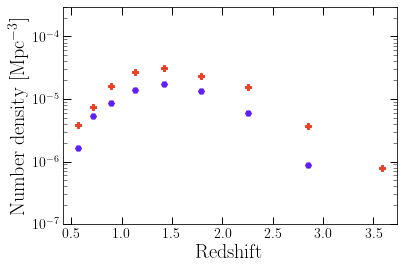

In [9]:
xray = otherruns['XLF']
ir = otherruns['IRLF']

# xray[0][2][2] = (xray[0][2][1] + xray[0][2][3])/2 

l_bins = (xray[2][:-1] + xray[2][1:])/2
z_bins = (xray[3][:-1]  + xray[3][1:])/2

flux_limit = 6.5e-15
l_limits = 4 * np.pi * cosmo.luminosity_distance(z_bins)**2 * flux_limit/(u.cm**2)
# l_limits = 4 * np.pi * cosmo.luminosity_distance((z_bins[:-1]+z_bins[1:])/2)**2 * flux_limit/(u.cm**2)
l_limits = l_limits.decompose()

for lim, lf in zip(l_limits, xray[0]):
    lum_lim_index = np.argmax(lim < l_bins)
    lf[:lum_lim_index] = 0

wavelength = 5.8
unit_conversion = 3 / wavelength * 1e-15
flux_limit = 43 * unit_conversion
l_limits = 4 * np.pi * cosmo.luminosity_distance(z_bins)**2 * flux_limit/(u.cm**2)
l_limits = l_limits.decompose()

# print(len(ir), l_limits.shape)
for lim, lf in zip(l_limits, ir[0]):
    lum_lim_index = np.argmax(lim < l_bins)
#     print(lum_lim_index)
    lf[:lum_lim_index] = 0
    
xmarker = 'H'
irmarker = 'P'
xcolor = 'xkcd:purplish blue'
ircolor = 'xkcd:tomato'
colors = ['xkcd:petrol', 'xkcd:royal', 'xkcd:red wine', 'xkcd:lilac', 'xkcd:cerulean', 'xkcd:aquamarine', 'xkcd:wine', 'xkcd:coral', 'xkcd:seafoam green']
lss = [(0, (3, 1, 1, 1)), (0, (5, 5)), (0, (1, 1)), (0, (3, 5, 1, 5, 1, 5))]

i = 3
j = -7
# print('Lum range:', l_bins[i], 'to', l_bins[-1], np.log10(l_bins[i]), np.log10(l_bins[j]))
fig, ax = plt.subplots()
num_density = np.trapz(xray[0][:, i:j], l_bins[i:j], axis=1)
print(num_density)
xrayplot = ax.scatter(z_bins, num_density, label='X-ray', color=xcolor, zorder=100, marker=xmarker)

ir_high = np.argmax(l_bins >= (l_bins[j]/10**fitparams[1])**(1/fitparams[0]))
ir_low = np.argmax(l_bins >= (l_bins[i]/10**fitparams[1])**(1/fitparams[0]))
# print(10**lin_fit(np.log10(l_bins[i:j]), *fitparams))
print(ir_low, ir_high)
num_density = np.trapz(ir[0][:, ir_low:ir_high], l_bins[ir_low:ir_high], axis=1)

print(num_density)
irplot = ax.scatter(z_bins, num_density, label='IR', color=ircolor, zorder=100, marker=irmarker)
# ax.scatter(z_bins, num_density, label='IR '+'{:.2f}'.format(np.log10(l_bins[ir_low])) +  r' $\leq \log_{10} L_{IR}/$erg s$^{-1} \leq$ ' + '{:.2f}'.format(np.log10(l_bins[ir_high])), color=ircolor, zorder=100, marker=irmarker)

# print(xray[0])
numde = np.sum(-(xray[2][:-1]-xray[2][1:])/2*xray[0], axis=1)
# ax.scatter(z_bins, numde, label='XLF2')
ax.set_yscale('log')
# lgd = ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
ax.set_ylim(bottom=1e-7, top=3e-4)
ax.set_xlabel('Redshift')
ax.set_ylabel(r'Number density [Mpc$^{-3}$]')
# ax.set_title('{:.2f}'.format(np.log10(l_bins[i])) +  r' $\leq \log_{10} L_X/$erg s$^{-1} \leq$ ' + '{:.2f}'.format(np.log10(l_bins[-1])))


# print(numde)
# print(z_bins)
# print(l_bins)

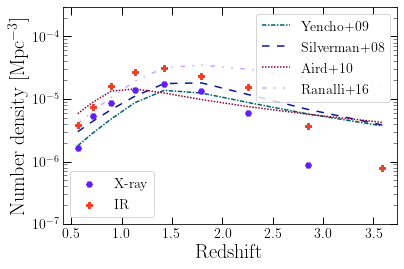

In [10]:
lines = (ls for ls in lss)
colo = (c for c in colors)

ls = np.logspace(np.log10(l_bins[i]), np.log10(l_bins[j]), num=200)
yencho_mid = af.LDDE(ls, z_bins, **yencho_ldde)
yencho_num = np.trapz(yencho_mid[:, :, 1] / ls, ls, axis=1)
yencho, = ax.plot(z_bins, yencho_num, label='Yencho+09', color=next(colo), ls=next(lines))
silverman_mid = af.LDDE(ls, z_bins, **silverman_ldde)
silverman_num = np.trapz(silverman_mid[:, :, 1] / ls, ls, axis=1)
silverman, = ax.plot(z_bins, silverman_num, label='Silverman+08', color=next(colo), ls=next(lines))
aird_mid = af.LDDE(ls, z_bins, **aird_ldde)
aird_num = np.trapz(aird_mid[:, :, 1] / ls, ls, axis=1)
aird, = ax.plot(z_bins, aird_num, label='Aird+10', color=next(colo), ls=next(lines))
ranalli_mid = af.LDDE(ls, z_bins, **ranalli_ldde)
ranalli_num = np.trapz(ranalli_mid[:, :, 1] / ls, ls, axis=1)
ranalli, = ax.plot(z_bins, ranalli_num, label='Ranalli+16', color=next(colo), ls=next(lines))

# print(silverman_num)
lgd = ax.legend(handles=[xrayplot, irplot], loc='lower left')
ax.add_artist(lgd)
ax.legend(handles=[yencho, silverman, aird, ranalli], loc='upper right')
fig.savefig('./output/paper_plots/num_density.pdf', bbox_extra_artists=(lgd,))

fig

Lum range: 1.287362385920042e+44 to 2.3896672374429255e+46


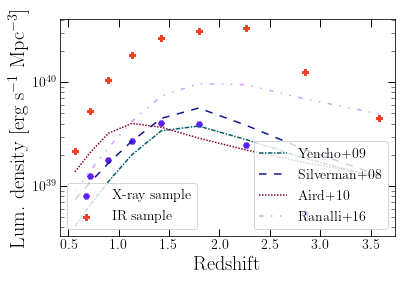

In [11]:
# i = 6
# j = None
print('Lum range:', l_bins[i], 'to', l_bins[-1])

lum_density = np.trapz(l_bins[i:j] * xray[0][:, i:j], l_bins[i:j], axis=1)

fig, ax = plt.subplots()
lines = (ls for ls in lss)
colo = (c for c in colors)

xrayplot = ax.scatter(z_bins, lum_density, label='X-ray sample', color=xcolor, marker=xmarker)
lum_density = np.trapz(l_bins[ir_low:ir_high] * ir[0][:, ir_low:ir_high], l_bins[ir_low:ir_high], axis=1)
irplot = ax.scatter(z_bins, lum_density, label='IR sample', color=ircolor, marker=irmarker)
ax.set_yscale('log')
ax.set_xlabel('Redshift')
ax.set_ylabel(r'Lum. density [erg s$^{-1}$ Mpc$^{-3}$]')

yencho_lum = np.trapz(yencho_mid[:, :, 1], ls, axis=1)
yencho, = ax.plot(z_bins, yencho_lum, label='Yencho+09', color=next(colo), ls=next(lines))
silverman_lum = np.trapz(silverman_mid[:, :, 1], ls, axis=1)
silverman, = ax.plot(z_bins, silverman_lum, label='Silverman+08', color=next(colo), ls=next(lines))
aird_lum = np.trapz(aird_mid[:, :, 1], ls, axis=1)
aird, = ax.plot(z_bins, aird_lum, label='Aird+10', color=next(colo), ls=next(lines))
ranalli_lum = np.trapz(ranalli_mid[:, :, 1], ls, axis=1)
ranalli, = ax.plot(z_bins, ranalli_lum, label='Ranalli+16', color=next(colo), ls=next(lines))

# aird_trial = np.loadtxt('./data/lum_dens_42_all.csv', delimiter=',')
# ax.plot(aird_trial[:, 0], aird_trial[:, 1], label=r'Aird $L_X > 10^{42}$ erg s$^{-1}$')
# aird_trial = np.loadtxt('./data/lum_dens_42_43.csv', delimiter=',')
# ax.plot(aird_trial[:, 0], aird_trial[:, 1], label=r'Aird $10^{43} > L_X > 10^{42}$ erg s$^{-1}$')
# aird_trial = np.loadtxt('./data/lum_dens_43_44.csv', delimiter=',')
# ax.plot(aird_trial[:, 0], aird_trial[:, 1], label=r'Aird $10^{44} > L_X > 10^{43}$ erg s$^{-1}$')

lgd = ax.legend(handles=[xrayplot, irplot], loc='lower left')
ax.add_artist(lgd)
ax.legend(handles=[yencho, silverman, aird, ranalli], loc='lower right')
# lgd = ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
# plt.ylim(bottom=1e39)

fig.savefig('./output/paper_plots/lum_density.pdf', bbox_extra_artists=(lgd,))

In [12]:
xray[0][-1]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.47224271e-51,
       5.69984372e-52, 9.34598592e-53, 9.12162340e-54, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [13]:
problem_bin = [np.trapz(xray[0][-1][:i], l_bins[:i]) for i in range(len(l_bins))]

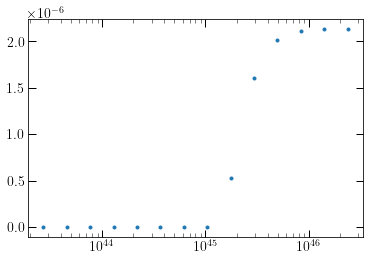

In [14]:
plt.plot(l_bins, problem_bin, '.')
# plt.yscale('log')
plt.xscale('log')

In [15]:
z_sample_min = 0.5
z_sample_max = 4
num_bins_z = 10
# redshift range 
z_bins = np.logspace(np.log10(z_sample_min), np.log10(z_sample_max), num=num_bins_z)
labels = [rf'{round(z_bins[i], 2)} $<$ z $\leq$ {round(z_bins[i+1], 2)}' for i in range(num_bins_z - 1)]
labels

['0.5 $<$ z $\\leq$ 0.63',
 '0.63 $<$ z $\\leq$ 0.79',
 '0.79 $<$ z $\\leq$ 1.0',
 '1.0 $<$ z $\\leq$ 1.26',
 '1.26 $<$ z $\\leq$ 1.59',
 '1.59 $<$ z $\\leq$ 2.0',
 '2.0 $<$ z $\\leq$ 2.52',
 '2.52 $<$ z $\\leq$ 3.17',
 '3.17 $<$ z $\\leq$ 4.0']

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


949


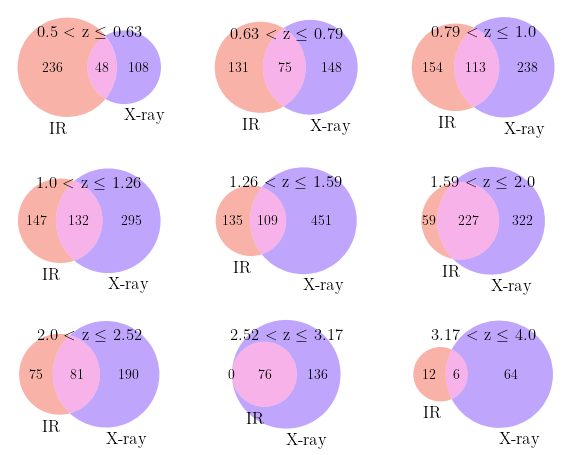

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
tot_ir = 0
for i, ax in enumerate(axs.flatten()):
#     ir_inbin = (cross_cat['full_zs'][cross_cat['ir_selected']] > z_bins[i]) & (cross_cat['full_zs'][cross_cat['ir_selected']] < z_bins[i+1]) #& ~cross_cat['ir_l'].mask
    ir_inbin = (ir_z[ir_in_cross_region] > z_bins[i]) & (ir_z[ir_in_cross_region] < z_bins[i+1]) #& ~cross_cat['ir_l'].mask
#     ir_inbin = (ir_z > z_bins[i]) & (ir_z < z_bins[i+1]) #& ~cross_cat['ir_l'].mask
#     x_inbin = (cross_cat['full_zs'][cross_cat['x_selected']] > z_bins[i]) & (cross_cat['full_zs'][cross_cat['x_selected']] < z_bins[i+1])# & ~cross_cat['x_l'].mask
    x_inbin = (x_z[x_in_cross_region] > z_bins[i]) & (x_z[x_in_cross_region] < z_bins[i+1])# & ~cross_cat['x_l'].mask
#     x_inbin = (x_z > z_bins[i]) & (x_z < z_bins[i+1])# & ~cross_cat['x_l'].mask
    cross_inbin = (cross_cat['full_zs'][cross_cat['both_selected_and_good']] > z_bins[i]) & (cross_cat['full_zs'][cross_cat['both_selected_and_good']] < z_bins[i+1])
#     print(np.sumxs(x_inbin), np.sum(ir_inbin), np.sum(cross_inbin))
    ir_count = np.sum(ir_inbin) - np.sum(cross_inbin)
    if ir_count < 0:
        ir_count = 0
        
    tot_ir += ir_count
    c = venn2(subsets=(ir_count, np.sum(x_inbin) - np.sum(cross_inbin), np.sum(cross_inbin)), set_labels=('IR', 'X-ray', 'Crossmatch'), ax=ax, set_colors=(ircolor, xcolor))

import matplotlib
fake_legend = matplotlib.lines.Line2D([], [], color="none")
for lab, ax in zip(labels, axs.flatten()):
#     handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[fake_legend], labels=[lab], loc='upper center', handlelength=0, handletextpad=0, markerscale=0, fontsize='large', frameon=False)
    
print(tot_ir)
fig.savefig('./output/paper_plots/venn_diagrams_redshifts.pdf')

In [17]:
z_bins[i]




3.174802103936399